In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import sqlite3
from tabulate import tabulate
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Objetivo do projeto
****
Desenvolver um modelo capaz de **prever quais usuários têm maior probabilidade de fazer uma segunda compra em até 30 dias após a realização da primeira**. Com isso, espera-se que o modelo tenha o <b>recall</b> de no mínimo <b style='color: green; font-size: larger'>70%</b> Segundo um estudo feito no passado, estes usuários possuem maior probabilidade de **fidelizar** na empresa e passar a realizar aquisições mensalmente.  
<b>PS: O recall responde a seguinte pergunta: quando o cliente fez uma segunda compra em até 30 dias, o quanto o modelo previu corretamente?</b>

O estudo que corrobora com a afirmativa é o seguinte:  

Kumar, V., & Reinartz, W. (2015). Creating enduring customer value. Journal of Marketing, 79(1), 36-68. https://doi.org/10.1509/jm.14.0100  
Esse estudo foi publicado na revista Journal of Marketing, uma das mais renomadas revistas acadêmicas na área de marketing.

# Conjunto de dados públicos de comércio eletrônico brasileiro por Olist
****
Este é um conjunto de dados público de comércio eletrônico brasileiro de pedidos feitos na Olist Store. O conjunto de dados contém informações de 100 mil pedidos de 2016 a 2018 feitos em vários marketplaces no Brasil. Seus recursos permitem visualizar um pedido de várias dimensões: desde o status do pedido, preço, pagamento e desempenho do frete até a localização do cliente, atributos do produto e, finalmente, avaliações escritas pelos clientes. Também lançamos um conjunto de dados de geolocalização que relaciona os códigos postais brasileiros às coordenadas lat/lng.

Estes são dados comerciais reais, foram anonimizados e as referências às empresas e parceiros no texto da revisão foram substituídas pelos nomes das grandes casas de Game of Thrones.

*url: www.kaggle.com/datasets/olistbr/brazilian-ecommerce*

## Sobre a Olist
Olist é uma plataforma de comércio eletrônico brasileira que conecta pequenas e médias empresas a grandes marketplaces, como Mercado Livre, Americanas.com, Submarino, Shoptime, Amazon, entre outros. A plataforma foi criada em 2015 e tem como objetivo ajudar os empreendedores a aumentarem suas vendas online, oferecendo uma solução completa que inclui integração com os principais marketplaces, gestão de estoque, gestão de pedidos, logística e suporte ao cliente.

# Pré-processamento dos dados
****
Nessa etapa, será realizado o pré-processamento dos dados para torná-lo adequados para o uso em um modelo de machine learning, como por exemplo, a criação de features e **target**, divisão entre a base de treino e teste, limpeza de dados. Será utilizado a Interface DB-API para banco de dados SQLite.
## Qual o cenário considerado para criar a base de dados?
**Serão coletados somente os dados da primeira compra de cada consumidor e que foram entregues com sucesso.**  
Dado que um novo cliente fez uma compra na plataforma e teve sua compra finalizada com a entrega do produto, será coletado:
- Localização do cliente;
- Reputação do(s) produto(s) comprados;    
- Reputação da categoria do(s) produto(s) comprados;
- Reputação do vendedor;
- Informações de entrega;
- Detalhes do valor da venda;
- Detalhes do pagamento;
- **[TARGET]** Flag indicando se o cliente fez uma segunda compra em até 30 dias após a primeira compra.  


**BASE DE DADOS ESPERADA AO FIM DO PRÉ-PROCESSAMENTO SQL**   

| customer_unique_id               | customer_state | order_review_score | mean_products_review_score | mean_category_products_review_score | mean_seller_review_score | distinct_sellers | delivery_estimated_day_difference | late_delivery | payment_installments | payment_value | freight_percent | **new_purchase_within_30_days** |
|----------------------------------|----------------|--------------------|----------------------------|-------------------------------------|--------------------------|------------------|-----------------------------------|---------------|----------------------|---------------|-----------------|---------------------------------|
| 861eff4711a542e4b93843c6dd7febb0 | SP             | 3.2                |3.5                         | 4.7                                 | 2.9                      | 1                | -7                                | 0             | 8                    | 99.33         | 0.15            | 1                               |
| 290c77bc529b7ac935b93aa66c333dc3 | SP             | 1.5                |2.2                         | 3.4                                 | 3.0                      | 2                | 3                                 | 1             | 2                    | 107.78        | 0.23            | 0                               |

## Criando e populando o banco de dados

In [2]:
conn   = sqlite3.connect('OListDB')
cursor = conn.cursor()

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        tablename = filename.replace('.csv', '').replace('olist_', '').replace('_dataset', '').upper()
        df = pd.read_csv(os.path.join(dirname, filename))
        df.to_sql(tablename, conn, if_exists='replace', index=False)  
        print(f'[OK] {filename} TO {tablename}')

[OK] olist_customers_dataset.csv TO CUSTOMERS
[OK] olist_sellers_dataset.csv TO SELLERS
[OK] olist_order_reviews_dataset.csv TO ORDER_REVIEWS
[OK] olist_order_items_dataset.csv TO ORDER_ITEMS
[OK] olist_products_dataset.csv TO PRODUCTS
[OK] olist_geolocation_dataset.csv TO GEOLOCATION
[OK] product_category_name_translation.csv TO PRODUCT_CATEGORY_NAME_TRANSLATION
[OK] olist_orders_dataset.csv TO ORDERS
[OK] olist_order_payments_dataset.csv TO ORDER_PAYMENTS


In [4]:
def get_query(SQL: str, tablefmt: str = 'github') -> str:
    query = cursor.execute(SQL)
    
    cols = [col[0] for col in query.description]
    rows = query.fetchall()
    
    return tabulate(rows, cols, tablefmt = tablefmt)


def create_table(SQL: str, tablename: str, tablefmt: str = 'github') -> str:
    try:
        cursor.execute(f'CREATE TABLE {tablename} AS {SQL}')
    except sqlite3.OperationalError:
        cursor.execute(f'DROP TABLE {tablename}')
        create_table(SQL, tablename)
    
    SQL_COUNT = f'''SELECT COUNT(1) AS QUANTITY FROM {tablename}'''
    
    return get_query(SQL_COUNT)

<h2 style="color: #CB4335"><strong>96.8%</strong> dos clientes compraram somente uma vez</h2>

In [5]:
SQL = '''
SELECT QTD_ORDER, COUNT(1) AS QTD FROM (
    SELECT CUSTOMER_UNIQUE_ID, COUNT(1) AS QTD_ORDER FROM (
        SELECT CUSTOMER_ID, CUSTOMER_UNIQUE_ID FROM CUSTOMERS
        ) 
        GROUP BY CUSTOMER_UNIQUE_ID
)
GROUP BY QTD_ORDER
'''

query = get_query(SQL)
print(query)

|   QTD_ORDER |   QTD |
|-------------|-------|
|           1 | 93099 |
|           2 |  2745 |
|           3 |   203 |
|           4 |    30 |
|           5 |     8 |
|           6 |     6 |
|           7 |     3 |
|           9 |     1 |
|          17 |     1 |


## Dados da primeira compra dos clientes considerando somente compras finalizadas (delivered)

In [6]:
# 274 dos 93.634 clientes estão repetidos porque eles compraram em mais de um vendedor na primeira compra
SQL_FIRST_ORDER = \
'''
SELECT OO.ORDER_ID             AS ORDER_ID 
     , CC.CUSTOMER_ID          AS CUSTOMER_ID
     , CO2.CUSTOMER_UNIQUE_ID  AS CUSTOMER_UNIQUE_ID
     , CC.CUSTOMER_STATE       AS CUSTOMER_STATE
     , CO2.FIRST_ORDER         AS FIRST_ORDER
  FROM (
        SELECT CO.CUSTOMER_UNIQUE_ID
             , MIN(CO.ORDER_PURCHASE_TIMESTAMP) AS FIRST_ORDER
          FROM (
                SELECT C.CUSTOMER_UNIQUE_ID
                     , O.ORDER_PURCHASE_TIMESTAMP
                  FROM CUSTOMERS C
                  JOIN ORDERS O 
                    ON O.CUSTOMER_ID  = C.CUSTOMER_ID 
                   AND O.ORDER_STATUS = 'delivered'
            ) CO
        GROUP BY CO.CUSTOMER_UNIQUE_ID
        ) CO2
  JOIN CUSTOMERS CC
    ON CC.CUSTOMER_UNIQUE_ID = CO2.CUSTOMER_UNIQUE_ID 
  JOIN ORDERS OO
    ON OO.CUSTOMER_ID = CC.CUSTOMER_ID
   AND OO.ORDER_PURCHASE_TIMESTAMP = CO2.FIRST_ORDER
'''

res = create_table(SQL_FIRST_ORDER, 'MV_FIRST_ORDER')
print(res)

|   QUANTITY |
|------------|
|      93634 |


In [7]:
SQL = '''
SELECT * FROM MV_FIRST_ORDER LIMIT 5
'''

query = get_query(SQL)
print(query)

| ORDER_ID                         | CUSTOMER_ID                      | CUSTOMER_UNIQUE_ID               | CUSTOMER_STATE   | FIRST_ORDER         |
|----------------------------------|----------------------------------|----------------------------------|------------------|---------------------|
| e22acc9c116caa3f2b7121bbb380d08e | fadbb3709178fc513abc1b2670aa1ad2 | 0000366f3b9a7992bf8c76cfdf3221e2 | SP               | 2018-05-10 10:56:27 |
| 3594e05a005ac4d06a72673270ef9ec9 | 4cb282e167ae9234755102258dd52ee8 | 0000b849f77a49e4a4ce2b2a4ca5be3f | SP               | 2018-05-07 11:11:27 |
| b33ec3b699337181488304f362a6b734 | 9b3932a6253894a02c1df9d19004239f | 0000f46a3911fa3c0805444483337064 | SC               | 2017-03-10 21:05:03 |
| 41272756ecddd9a9ed0180413cc22fb6 | 914991f0c02ef0843c0e7010c819d642 | 0000f6ccb0745a6a4b88665a16c9f078 | PA               | 2017-10-12 20:29:41 |
| d957021f1127559cd947b62533f484f7 | 47227568b10f5f58a524a75507e6992c | 0004aac84e0df4da2b147fca70cf8255 | SP   

## Dados da entrega: verificar se houve atraso na entrega e diferença entre o dia da entrega e o dia estimado da entrega

In [8]:
# 21 Compras não possuem data de entrega preenchidos
SQL_ORDER_DELIVERY = \
'''
SELECT OO.ORDER_ID                                    AS ORDER_ID
     , OO.DELIVERY_ESTIMATED_DAY_DIFFERENCE           AS DELIVERY_ESTIMATED_DAY_DIFFERENCE
     , CASE                                  
       WHEN OO.DELIVERY_ESTIMATED_DAY_DIFFERENCE < 0
         THEN 1
         ELSE 0
       END                                            AS LATE_DELIVERY
  FROM (
        SELECT O.ORDER_ID
             , CAST ( JulianDay(O.ORDER_ESTIMATED_DELIVERY_DATE) - JulianDay(O.ORDER_DELIVERED_CUSTOMER_DATE) AS INTEGER) AS delivery_estimated_day_difference
          FROM ORDERS O
          JOIN MV_FIRST_ORDER FO
            ON FO.CUSTOMER_ID = O.CUSTOMER_ID
         WHERE O.ORDER_STATUS = 'delivered'
        ) OO
 
'''

res = create_table(SQL_ORDER_DELIVERY, 'MV_ORDER_DELIVERY')
print(res)

|   QUANTITY |
|------------|
|      93613 |


In [9]:
SQL = '''SELECT * FROM MV_ORDER_DELIVERY LIMIT 5'''

query = get_query(SQL)
print(query)

| ORDER_ID                         |   DELIVERY_ESTIMATED_DAY_DIFFERENCE |   LATE_DELIVERY |
|----------------------------------|-------------------------------------|-----------------|
| 53cdb2fc8bc7dce0b6741e2150273451 |                                   5 |               0 |
| 47770eb9100c2d0c44946d9cf07ec65d |                                  17 |               0 |
| 949d5b44dbf5de918fe9c16f97b45f8a |                                  12 |               0 |
| ad21c59c0840e6cb83a9ceb5573f8159 |                                   9 |               0 |
| a4591c265e18cb1dcee52889e2d8acc3 |                                   5 |               0 |


## Dados do pagamento: tipo do pagamento, número de parcelas, valor total e percentual do frete

In [10]:
# 5 Registros ficaram de fora porque não tinham informações de pagamento ou não tinham informações dos itens da compra
SQL_PAYMENTS = \
'''
SELECT PP.ORDER_ID                                 AS ORDER_ID
     , PP.PAYMENT_INSTALLMENTS                     AS PAYMENT_INSTALLMENTS
     , PP.PAYMENT_VALUE                            AS PAYMENT_VALUE
     , ROUND(I.FREIGHT_VALUE/PP.PAYMENT_VALUE, 2)  AS FREIGHT_PERCENT
  FROM (
        SELECT P.ORDER_ID                                AS ORDER_ID
             , MAX(P.PAYMENT_INSTALLMENTS)               AS PAYMENT_INSTALLMENTS
             , SUM(P.PAYMENT_VALUE)                      AS PAYMENT_VALUE
          FROM ORDER_PAYMENTS P
        GROUP BY P.ORDER_ID
       ) PP
  JOIN (
        SELECT I.ORDER_ID           AS ORDER_ID
             , SUM(I.FREIGHT_VALUE) AS FREIGHT_VALUE
          FROM ORDER_ITEMS I
        GROUP BY I.ORDER_ID
        ) I
    ON I.ORDER_ID = PP.ORDER_ID
 JOIN MV_FIRST_ORDER O 
   ON O.ORDER_ID = I.ORDER_ID
'''

res = create_table(SQL_PAYMENTS, 'MV_ORDER_PAYMENTS')
print(res)

|   QUANTITY |
|------------|
|      93629 |


In [11]:
SQL = '''SELECT * FROM MV_ORDER_PAYMENTS LIMIT 5'''

query = get_query(SQL)
print(query)

| ORDER_ID                         |   PAYMENT_INSTALLMENTS |   PAYMENT_VALUE |   FREIGHT_PERCENT |
|----------------------------------|------------------------|-----------------|-------------------|
| 00010242fe8c5a6d1ba2dd792cb16214 |                      2 |           72.19 |              0.18 |
| 00018f77f2f0320c557190d7a144bdd3 |                      3 |          259.83 |              0.08 |
| 000229ec398224ef6ca0657da4fc703e |                      5 |          216.87 |              0.08 |
| 00024acbcdf0a6daa1e931b038114c75 |                      2 |           25.78 |              0.5  |
| 00042b26cf59d7ce69dfabb4e55b4fd9 |                      3 |          218.04 |              0.08 |


## Dados da review da compra, do vendedor, do produto e da categoria do produto.


In [12]:
# 620 compras não tiveram avaliações
SQL_ORDER_SCORE = \
'''
SELECT R.ORDER_ID, R.REVIEW_SCORE
  FROM ORDER_REVIEWS R
  JOIN MV_FIRST_ORDER FO
    ON FO.ORDER_ID = R.ORDER_ID
'''

res = create_table(SQL_ORDER_SCORE, 'MV_ORDER_REVIEW_SCORE')
print(res)

|   QUANTITY |
|------------|
|      93378 |


In [13]:
SQL = '''
SELECT * FROM MV_ORDER_REVIEW_SCORE LIMIT 5
'''

query = get_query(SQL)
print(query)

| order_id                         |   review_score |
|----------------------------------|----------------|
| 73fc7af87114b39712e6da79b0a377eb |              4 |
| a548910a1c6147796b98fdf73dbeba33 |              5 |
| f9e4b658b201a9f2ecdecbb34bed034b |              5 |
| 658677c97b385a9be170737859d3511b |              5 |
| 8e6bfb81e283fa7e4f11123a3fb894f1 |              5 |


In [14]:
# 14 compras foram realizadas com mais de um vendedor
SQL_SELLER_SCORE = \
'''
SELECT I.SELLER_ID                   AS SELLER_ID
     , ROUND(AVG(R.REVIEW_SCORE), 1) AS MEAN_SELLER_REVIEW_SCORE
  FROM ORDER_REVIEWS R
  JOIN ORDERS O 
    ON O.ORDER_ID = R.ORDER_ID
  JOIN ORDER_ITEMS I
    ON I.ORDER_ID = R.ORDER_ID
  JOIN MV_FIRST_ORDER FO
    ON FO.ORDER_ID = R.ORDER_ID
 GROUP BY I.SELLER_ID
'''

res = create_table(SQL_SELLER_SCORE, 'MV_SELLER_REVIEW_SCORE')
print(res)

|   QUANTITY |
|------------|
|       2951 |


In [15]:
SQL = '''
SELECT * FROM MV_SELLER_REVIEW_SCORE LIMIT 5
'''

query = get_query(SQL)
print(query)

| SELLER_ID                        |   MEAN_SELLER_REVIEW_SCORE |
|----------------------------------|----------------------------|
| 0015a82c2db000af6aaaf3ae2ecb0532 |                        3.7 |
| 001cca7ae9ae17fb1caed9dfb1094831 |                        4   |
| 002100f778ceb8431b7a1020ff7ab48f |                        4.1 |
| 003554e2dce176b5555353e4f3555ac8 |                        5   |
| 004c9cd9d87a3c30c522c48c4fc07416 |                        4.1 |


In [16]:
SQL_PRODUCT_SCORE = \
'''
SELECT I.PRODUCT_ID                   AS PRODUCT_ID
     , ROUND(AVG(R.REVIEW_SCORE), 1) AS MEAN_PRODUCT_REVIEW_SCORE
  FROM ORDER_REVIEWS R
  JOIN ORDERS O 
    ON O.ORDER_ID = R.ORDER_ID
  JOIN ORDER_ITEMS I
    ON I.ORDER_ID = R.ORDER_ID
  JOIN MV_FIRST_ORDER FO
    ON FO.ORDER_ID = R.ORDER_ID
 GROUP BY I.PRODUCT_ID
'''

res = create_table(SQL_PRODUCT_SCORE, 'MV_PRODUCT_REVIEW_SCORE')
print(res)

|   QUANTITY |
|------------|
|      31384 |


In [17]:
SQL = '''
SELECT * FROM MV_PRODUCT_REVIEW_SCORE LIMIT 5
'''

query = get_query(SQL)
print(query)

| PRODUCT_ID                       |   MEAN_PRODUCT_REVIEW_SCORE |
|----------------------------------|-----------------------------|
| 00066f42aeeb9f3007548bb9d3f33c38 |                           5 |
| 00088930e925c41fd95ebfe695fd2655 |                           4 |
| 0009406fd7479715e4bef61dd91f2462 |                           1 |
| 000b8f95fcb9e0096488278317764d19 |                           5 |
| 000d9be29b5207b54e86aa1b1ac54872 |                           5 |


In [18]:
SQL_PRODUCT_CATEGORY_SCORE = \
'''
SELECT PC.PRODUCT_CATEGORY_NAME                     AS PRODUCT_CATEGORY_NAME
     , ROUND(AVG(PC.MEAN_PRODUCT_REVIEW_SCORE ), 1) AS MEAN_PRODUCT_CATEGORY_REVIEW_SCORE
  FROM (
        SELECT I.PRODUCT_ID                   AS PRODUCT_ID
             , P.PRODUCT_CATEGORY_NAME        AS PRODUCT_CATEGORY_NAME
             , ROUND(AVG(R.REVIEW_SCORE), 1)  AS MEAN_PRODUCT_REVIEW_SCORE
          FROM ORDER_REVIEWS R
          JOIN ORDERS O 
            ON O.ORDER_ID = R.ORDER_ID
          JOIN ORDER_ITEMS I
            ON I.ORDER_ID = R.ORDER_ID
          JOIN PRODUCTS P
            ON P.PRODUCT_ID = I.PRODUCT_ID
          JOIN MV_FIRST_ORDER FO
            ON FO.ORDER_ID = R.ORDER_ID
         GROUP BY I.PRODUCT_ID
                , P.PRODUCT_CATEGORY_NAME
        ) PC
GROUP BY PC.PRODUCT_CATEGORY_NAME
'''

res = create_table(SQL_PRODUCT_CATEGORY_SCORE, 'MV_PRODUCT_CATEGORY_REVIEW_SCORE')
print(res)

|   QUANTITY |
|------------|
|         74 |


In [19]:
SQL = '''
SELECT * FROM MV_PRODUCT_CATEGORY_REVIEW_SCORE LIMIT 5
'''

query = get_query(SQL)
print(query)

| PRODUCT_CATEGORY_NAME     |   MEAN_PRODUCT_CATEGORY_REVIEW_SCORE |
|---------------------------|--------------------------------------|
|                           |                                  4   |
| agro_industria_e_comercio |                                  4   |
| alimentos                 |                                  4.3 |
| alimentos_bebidas         |                                  4.5 |
| artes                     |                                  4.3 |


## Contagem de vendedores distintos por compra

In [20]:
SQL_DISTINCT_SELLERS = \
'''
SELECT FO.CUSTOMER_UNIQUE_ID AS CUSTOMER_UNIQUE_ID
     , COUNT(1)              AS DISTINCT_SELLERS 
 FROM MV_FIRST_ORDER FO
GROUP BY FO.CUSTOMER_UNIQUE_ID
'''

res = create_table(SQL_DISTINCT_SELLERS, 'MV_DISTINCT_SELLERS')
print(res)

|   QUANTITY |
|------------|
|      93358 |


In [21]:
SQL = '''
SELECT * FROM MV_DISTINCT_SELLERS 
WHERE DISTINCT_SELLERS > 1
LIMIT 5
'''

query = get_query(SQL)
print(query)

| CUSTOMER_UNIQUE_ID               |   DISTINCT_SELLERS |
|----------------------------------|--------------------|
| 02b20b7c813efede140142ac610e36dc |                  2 |
| 031e19fc630c4121f1238716f41675c3 |                  2 |
| 050555c26479bbb8ba0740c37e7454d0 |                  2 |
| 06a52782a04f0086d16b9c22d0e29438 |                  2 |
| 0710e0c85fe7cb494d624e0863782e46 |                  2 |


## Obter os clientes que fizeram uma nova compra em até 30 dias

In [22]:
SQL_SEC_ORDER_WITHIN_30 = \
'''
SELECT SO.CUSTOMER_UNIQUE_ID                                                                          AS CUSTOMER_UNIQUE_ID
     , CASE WHEN CAST ( JulianDay(SO.SECOND_ORDER) - JulianDay(SO.FIRST_ORDER) AS INTEGER) <= 30
         THEN 1
         ELSE 0
       END                                                                                            AS SECOND_ORDER_WITHIN_30_DAYS  
  FROM (
        SELECT FO.CUSTOMER_UNIQUE_ID           AS CUSTOMER_UNIQUE_ID 
             , FO.FIRST_ORDER                  AS FIRST_ORDER
             , MIN(O.ORDER_PURCHASE_TIMESTAMP) AS SECOND_ORDER
          FROM ORDERS O
          JOIN CUSTOMERS C
            ON O.CUSTOMER_ID = C.CUSTOMER_ID
          JOIN MV_FIRST_ORDER FO
            ON FO.CUSTOMER_UNIQUE_ID = C.CUSTOMER_UNIQUE_ID
           AND FO.FIRST_ORDER <> O.ORDER_PURCHASE_TIMESTAMP
        GROUP BY FO.CUSTOMER_UNIQUE_ID
) SO
'''

res = create_table(SQL_SEC_ORDER_WITHIN_30, 'MV_SECOND_ORDER_WITHIN_30_DAYS')
print(res)

|   QUANTITY |
|------------|
|       2725 |


In [23]:
SQL = '''
SELECT * FROM MV_SECOND_ORDER_WITHIN_30_DAYS SO30 LIMIT 5
'''

query = get_query(SQL)
print(query)

| CUSTOMER_UNIQUE_ID               |   SECOND_ORDER_WITHIN_30_DAYS |
|----------------------------------|-------------------------------|
| 00172711b30d52eea8b313a7f2cced02 |                             1 |
| 004288347e5e88a27ded2bb23747066c |                             0 |
| 004b45ec5c64187465168251cd1c9c2f |                             1 |
| 0058f300f57d7b93c477a131a59b36c3 |                             1 |
| 00a39521eb40f7012db50455bf083460 |                             1 |


In [24]:
SQL = '''
SELECT SECOND_ORDER_WITHIN_30_DAYS, COUNT(1) AS "CUSTOMERS_WHO_PURCHASED_MORE_THAN_ONCE" FROM MV_SECOND_ORDER_WITHIN_30_DAYS SO30 GROUP BY SECOND_ORDER_WITHIN_30_DAYS
'''

query = get_query(SQL)
print(query)

|   SECOND_ORDER_WITHIN_30_DAYS |   CUSTOMERS_WHO_PURCHASED_MORE_THAN_ONCE |
|-------------------------------|------------------------------------------|
|                             0 |                                     1420 |
|                             1 |                                     1305 |


## Unindo dataset

In [25]:
DATASET = \
'''
SELECT    D.CUSTOMER_STATE
        , D.DISTINCT_SELLERS
        , D.DELIVERY_ESTIMATED_DAY_DIFFERENCE
        , D.LATE_DELIVERY
        , D.PAYMENT_INSTALLMENTS
        , D.PAYMENT_VALUE
        , D.FREIGHT_PERCENT
        , D.ORDER_REVIEW_SCORE
        , D.MEAN_SELLER_REVIEW_SCORE
        , D.MEAN_PRODUCT_REVIEW_SCORE
        , D.MEAN_PRODUCT_CATEGORY_REVIEW_SCORE
        , D.SECOND_ORDER_WITHIN_30_DAYS
FROM (
        SELECT FO.CUSTOMER_UNIQUE_ID                            AS CUSTOMER_UNIQUE_ID
             , MAX(FO.CUSTOMER_STATE)                           AS CUSTOMER_STATE
             , AVG(DS.DISTINCT_SELLERS)                         AS DISTINCT_SELLERS
             , AVG(OD.DELIVERY_ESTIMATED_DAY_DIFFERENCE)        AS DELIVERY_ESTIMATED_DAY_DIFFERENCE
             , AVG(OD.LATE_DELIVERY)                            AS LATE_DELIVERY
             , AVG(OP.PAYMENT_INSTALLMENTS)                     AS PAYMENT_INSTALLMENTS
             , AVG(OP.PAYMENT_VALUE)                            AS PAYMENT_VALUE
             , AVG(OP.FREIGHT_PERCENT)                          AS FREIGHT_PERCENT
             , AVG(OS.REVIEW_SCORE)                             AS ORDER_REVIEW_SCORE
             , AVG(SS.MEAN_SELLER_REVIEW_SCORE)                 AS MEAN_SELLER_REVIEW_SCORE
             , AVG(PS.MEAN_PRODUCT_REVIEW_SCORE)                AS MEAN_PRODUCT_REVIEW_SCORE
             , AVG(CS.MEAN_PRODUCT_CATEGORY_REVIEW_SCORE)       AS MEAN_PRODUCT_CATEGORY_REVIEW_SCORE
             , IFNULL(SO30.SECOND_ORDER_WITHIN_30_DAYS, 0)      AS SECOND_ORDER_WITHIN_30_DAYS
        FROM MV_FIRST_ORDER FO
        LEFT JOIN MV_DISTINCT_SELLERS DS
          ON FO.CUSTOMER_UNIQUE_ID = DS.CUSTOMER_UNIQUE_ID
        LEFT JOIN MV_ORDER_DELIVERY OD
          ON FO.ORDER_ID = OD.ORDER_ID
        LEFT JOIN MV_ORDER_PAYMENTS OP
          ON FO.ORDER_ID = OP.ORDER_ID
        LEFT JOIN MV_ORDER_REVIEW_SCORE OS
          ON FO.ORDER_ID = OS.ORDER_ID
        JOIN ORDER_ITEMS I
          ON FO.ORDER_ID = I.ORDER_ID
        LEFT JOIN MV_SELLER_REVIEW_SCORE SS
          ON SS.SELLER_ID = I.SELLER_ID
        LEFT JOIN MV_PRODUCT_REVIEW_SCORE PS
          ON PS.PRODUCT_ID = I.PRODUCT_ID
        JOIN PRODUCTS P
          ON P.PRODUCT_ID = I.PRODUCT_ID
        LEFT JOIN MV_PRODUCT_CATEGORY_REVIEW_SCORE CS
          ON CS.PRODUCT_CATEGORY_NAME = P.PRODUCT_CATEGORY_NAME
        LEFT JOIN MV_SECOND_ORDER_WITHIN_30_DAYS SO30
          ON FO.CUSTOMER_UNIQUE_ID = SO30.CUSTOMER_UNIQUE_ID
        GROUP BY FO.CUSTOMER_UNIQUE_ID
) D
'''

res = create_table(DATASET, 'DATASET')
print(res)

|   QUANTITY |
|------------|
|      93358 |


In [26]:
DATASET = '''
SELECT * FROM DATASET D LIMIT 5
'''

query = get_query(DATASET)
print(query)

| CUSTOMER_STATE   |   DISTINCT_SELLERS |   DELIVERY_ESTIMATED_DAY_DIFFERENCE |   LATE_DELIVERY |   PAYMENT_INSTALLMENTS |   PAYMENT_VALUE |   FREIGHT_PERCENT |   ORDER_REVIEW_SCORE |   MEAN_SELLER_REVIEW_SCORE |   MEAN_PRODUCT_REVIEW_SCORE |   MEAN_PRODUCT_CATEGORY_REVIEW_SCORE |   SECOND_ORDER_WITHIN_30_DAYS |
|------------------|--------------------|-------------------------------------|-----------------|------------------------|-----------------|-------------------|----------------------|----------------------------|-----------------------------|--------------------------------------|-------------------------------|
| SP               |                  1 |                                   4 |               0 |                      8 |          141.9  |              0.08 |                    5 |                        4.1 |                         4.2 |                                  3.9 |                             0 |
| SP               |                  1 |                 

In [27]:
DATASET = '''
SELECT * FROM DATASET D LIMIT 5
'''

query = get_query(DATASET)
print(query)

| CUSTOMER_STATE   |   DISTINCT_SELLERS |   DELIVERY_ESTIMATED_DAY_DIFFERENCE |   LATE_DELIVERY |   PAYMENT_INSTALLMENTS |   PAYMENT_VALUE |   FREIGHT_PERCENT |   ORDER_REVIEW_SCORE |   MEAN_SELLER_REVIEW_SCORE |   MEAN_PRODUCT_REVIEW_SCORE |   MEAN_PRODUCT_CATEGORY_REVIEW_SCORE |   SECOND_ORDER_WITHIN_30_DAYS |
|------------------|--------------------|-------------------------------------|-----------------|------------------------|-----------------|-------------------|----------------------|----------------------------|-----------------------------|--------------------------------------|-------------------------------|
| SP               |                  1 |                                   4 |               0 |                      8 |          141.9  |              0.08 |                    5 |                        4.1 |                         4.2 |                                  3.9 |                             0 |
| SP               |                  1 |                 

In [28]:
df = pd.read_sql('SELECT * FROM DATASET', conn)
df.head()

,CUSTOMER_STATE,DISTINCT_SELLERS,DELIVERY_ESTIMATED_DAY_DIFFERENCE,LATE_DELIVERY,PAYMENT_INSTALLMENTS,PAYMENT_VALUE,FREIGHT_PERCENT,ORDER_REVIEW_SCORE,MEAN_SELLER_REVIEW_SCORE,MEAN_PRODUCT_REVIEW_SCORE,MEAN_PRODUCT_CATEGORY_REVIEW_SCORE,SECOND_ORDER_WITHIN_30_DAYS
0,SP,1.0,4.0,0.0,8.0,141.90,0.08,5.0,4.1,4.2,3.9,0
1,SP,1.0,4.0,0.0,1.0,27.19,0.30,4.0,4.0,4.7,4.2,0
2,SC,1.0,1.0,0.0,8.0,86.22,0.20,3.0,4.1,4.6,4.3,0
3,PA,1.0,11.0,0.0,4.0,43.62,0.40,4.0,3.9,4.7,4.0,0
4,SP,1.0,7.0,0.0,6.0,196.89,0.09,5.0,3.8,5.0,4.0,0


# Análise exploratória dos dados
****

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [30]:
def get_dtypes(df):
    feat_cat = df.select_dtypes(include=['category', 'object']).columns.to_list()
    feat_num = df.select_dtypes(exclude =['category', 'object']).columns.to_list()
    
    feat_num.remove('SECOND_ORDER_WITHIN_30_DAYS')
    
    return feat_cat, feat_num

## Contagem de nulos
- **DELIVERY_ESTIMATED_DAY_DIFFERENCE:** entregas que não tem data de entrega preenchida;
- **PAYMENT_INSTALLMENTS, PAYMENT_VALUE & FREIGHT_PERCENT:** compra que não tem registro de pagamento;
- **ORDER_REVIEW_SCORE:** compras que não dados de review;
- **MEAN_SELLER_REVIEW_SCORE:** compras que não dados de review;
- **MEAN_PRODUCT_REVIEW_SCORE:** produtos que não tem dados de review;
- **MEAN_PRODUCT_CATEGORY_REVIEW_SCORE**: categorias de produtos que não tem dados de review.


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93358 entries, 0 to 93357
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   CUSTOMER_STATE                      93358 non-null  object 
 1   DISTINCT_SELLERS                    93358 non-null  float64
 2   DELIVERY_ESTIMATED_DAY_DIFFERENCE   93350 non-null  float64
 3   LATE_DELIVERY                       93358 non-null  float64
 4   PAYMENT_INSTALLMENTS                93357 non-null  float64
 5   PAYMENT_VALUE                       93357 non-null  float64
 6   FREIGHT_PERCENT                     93357 non-null  float64
 7   ORDER_REVIEW_SCORE                  92743 non-null  float64
 8   MEAN_SELLER_REVIEW_SCORE            93354 non-null  float64
 9   MEAN_PRODUCT_REVIEW_SCORE           93237 non-null  float64
 10  MEAN_PRODUCT_CATEGORY_REVIEW_SCORE  92071 non-null  float64
 11  SECOND_ORDER_WITHIN_30_DAYS         93358

In [32]:
# Nulos por classe
for attr, sum_null in df.isnull().sum().items():
    if sum_null:
        res = np.unique(df.loc[df[attr].isnull()]['SECOND_ORDER_WITHIN_30_DAYS'], return_counts = True)
        print('='*30)
        print(f'{attr}\n{res}')

DELIVERY_ESTIMATED_DAY_DIFFERENCE
(array([0]), array([8]))
PAYMENT_INSTALLMENTS
(array([0]), array([1]))
PAYMENT_VALUE
(array([0]), array([1]))
FREIGHT_PERCENT
(array([0]), array([1]))
ORDER_REVIEW_SCORE
(array([0, 1]), array([606,   9]))
MEAN_SELLER_REVIEW_SCORE
(array([0]), array([4]))
MEAN_PRODUCT_REVIEW_SCORE
(array([0]), array([121]))
MEAN_PRODUCT_CATEGORY_REVIEW_SCORE
(array([0, 1]), array([1273,   14]))


## Matriz de correlação
- A boa avaliação do produto possui alta correlação (60%) com a avaliação da compra;
- A demora na entrega possui uma correlação negativa fraca (-39%) com a avaliação da compra.

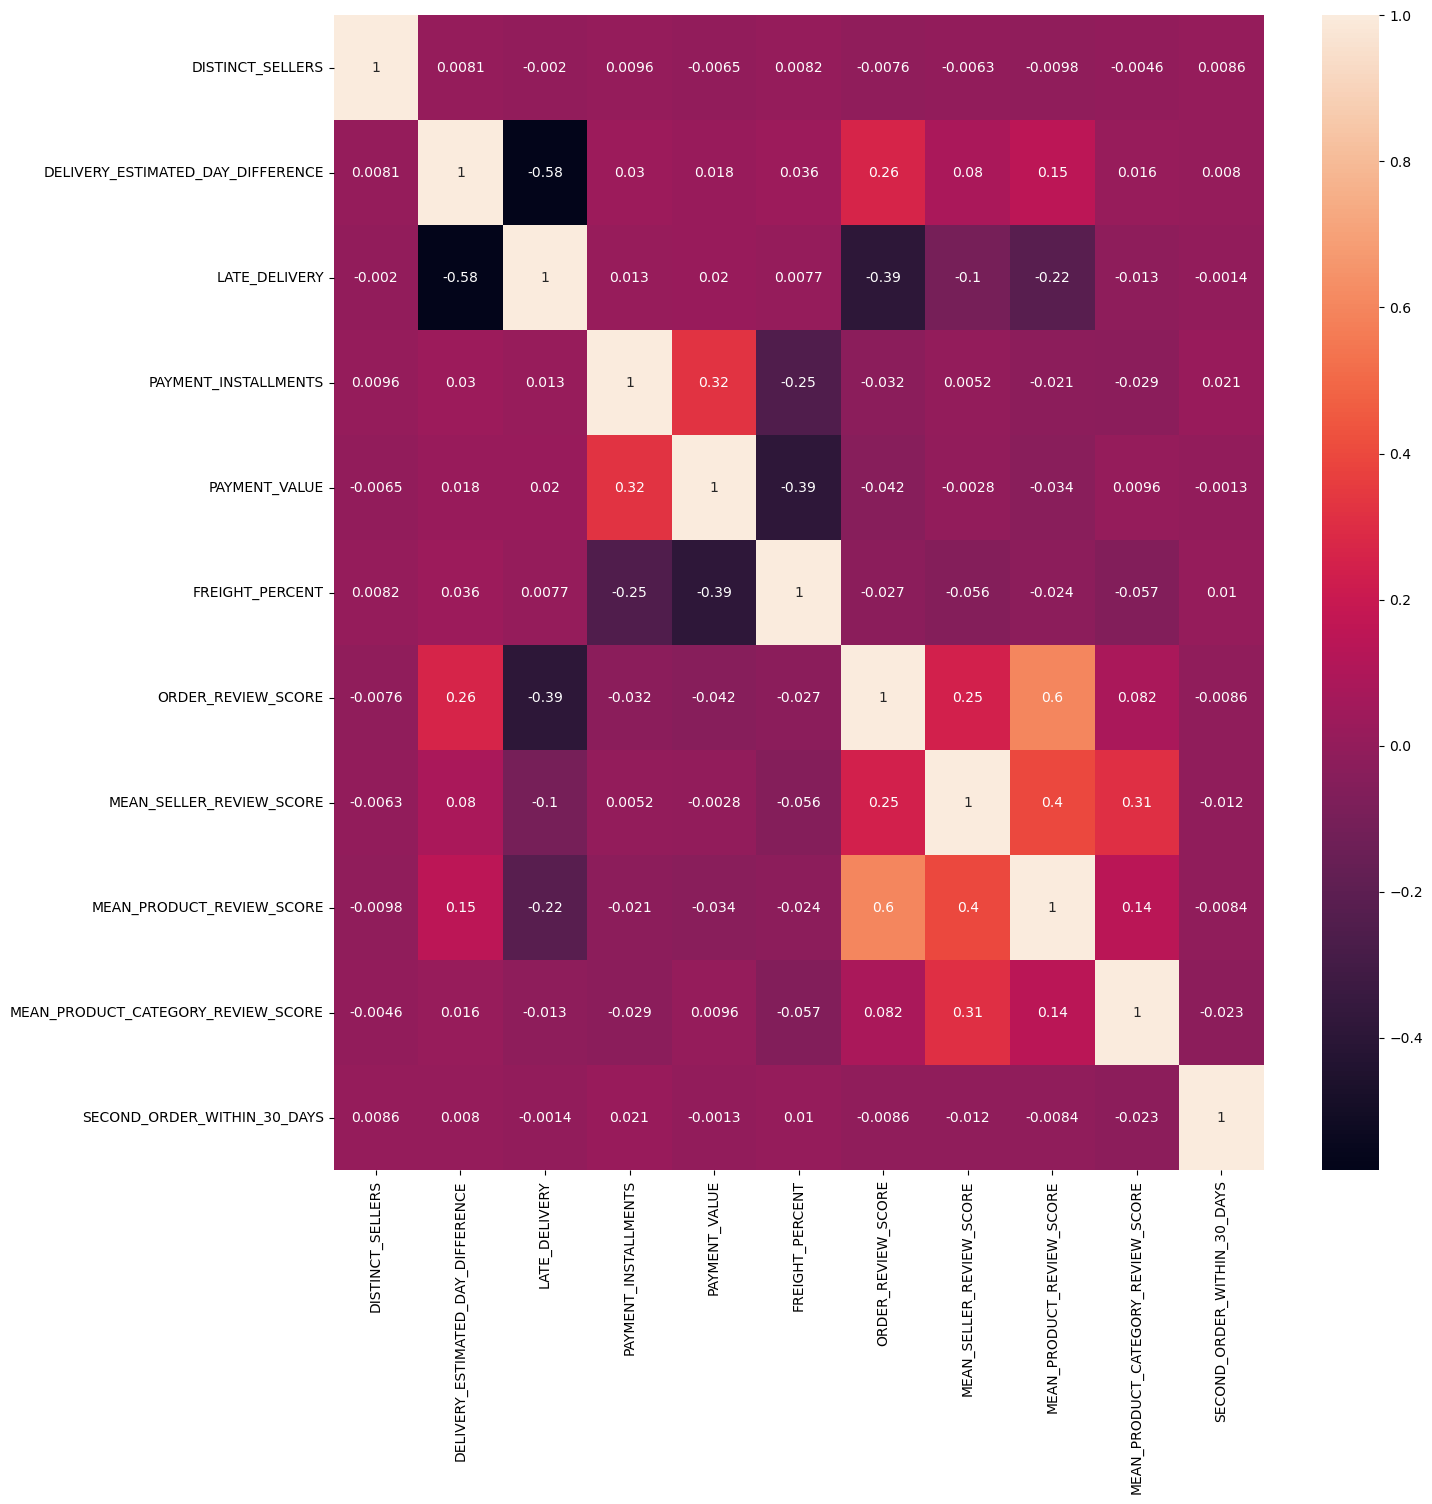

In [33]:
fig = plt.figure(figsize = (15, 15))
sns.heatmap(df.corr(), annot = True);

## Distribuição dos dados
Dados não estão normalmente distribuidos

In [34]:
feat_cat, feat_num = get_dtypes(df)
feat_cat, feat_num

(['CUSTOMER_STATE'],
 ['DISTINCT_SELLERS',
  'DELIVERY_ESTIMATED_DAY_DIFFERENCE',
  'LATE_DELIVERY',
  'PAYMENT_INSTALLMENTS',
  'PAYMENT_VALUE',
  'FREIGHT_PERCENT',
  'ORDER_REVIEW_SCORE',
  'MEAN_SELLER_REVIEW_SCORE',
  'MEAN_PRODUCT_REVIEW_SCORE',
  'MEAN_PRODUCT_CATEGORY_REVIEW_SCORE'])

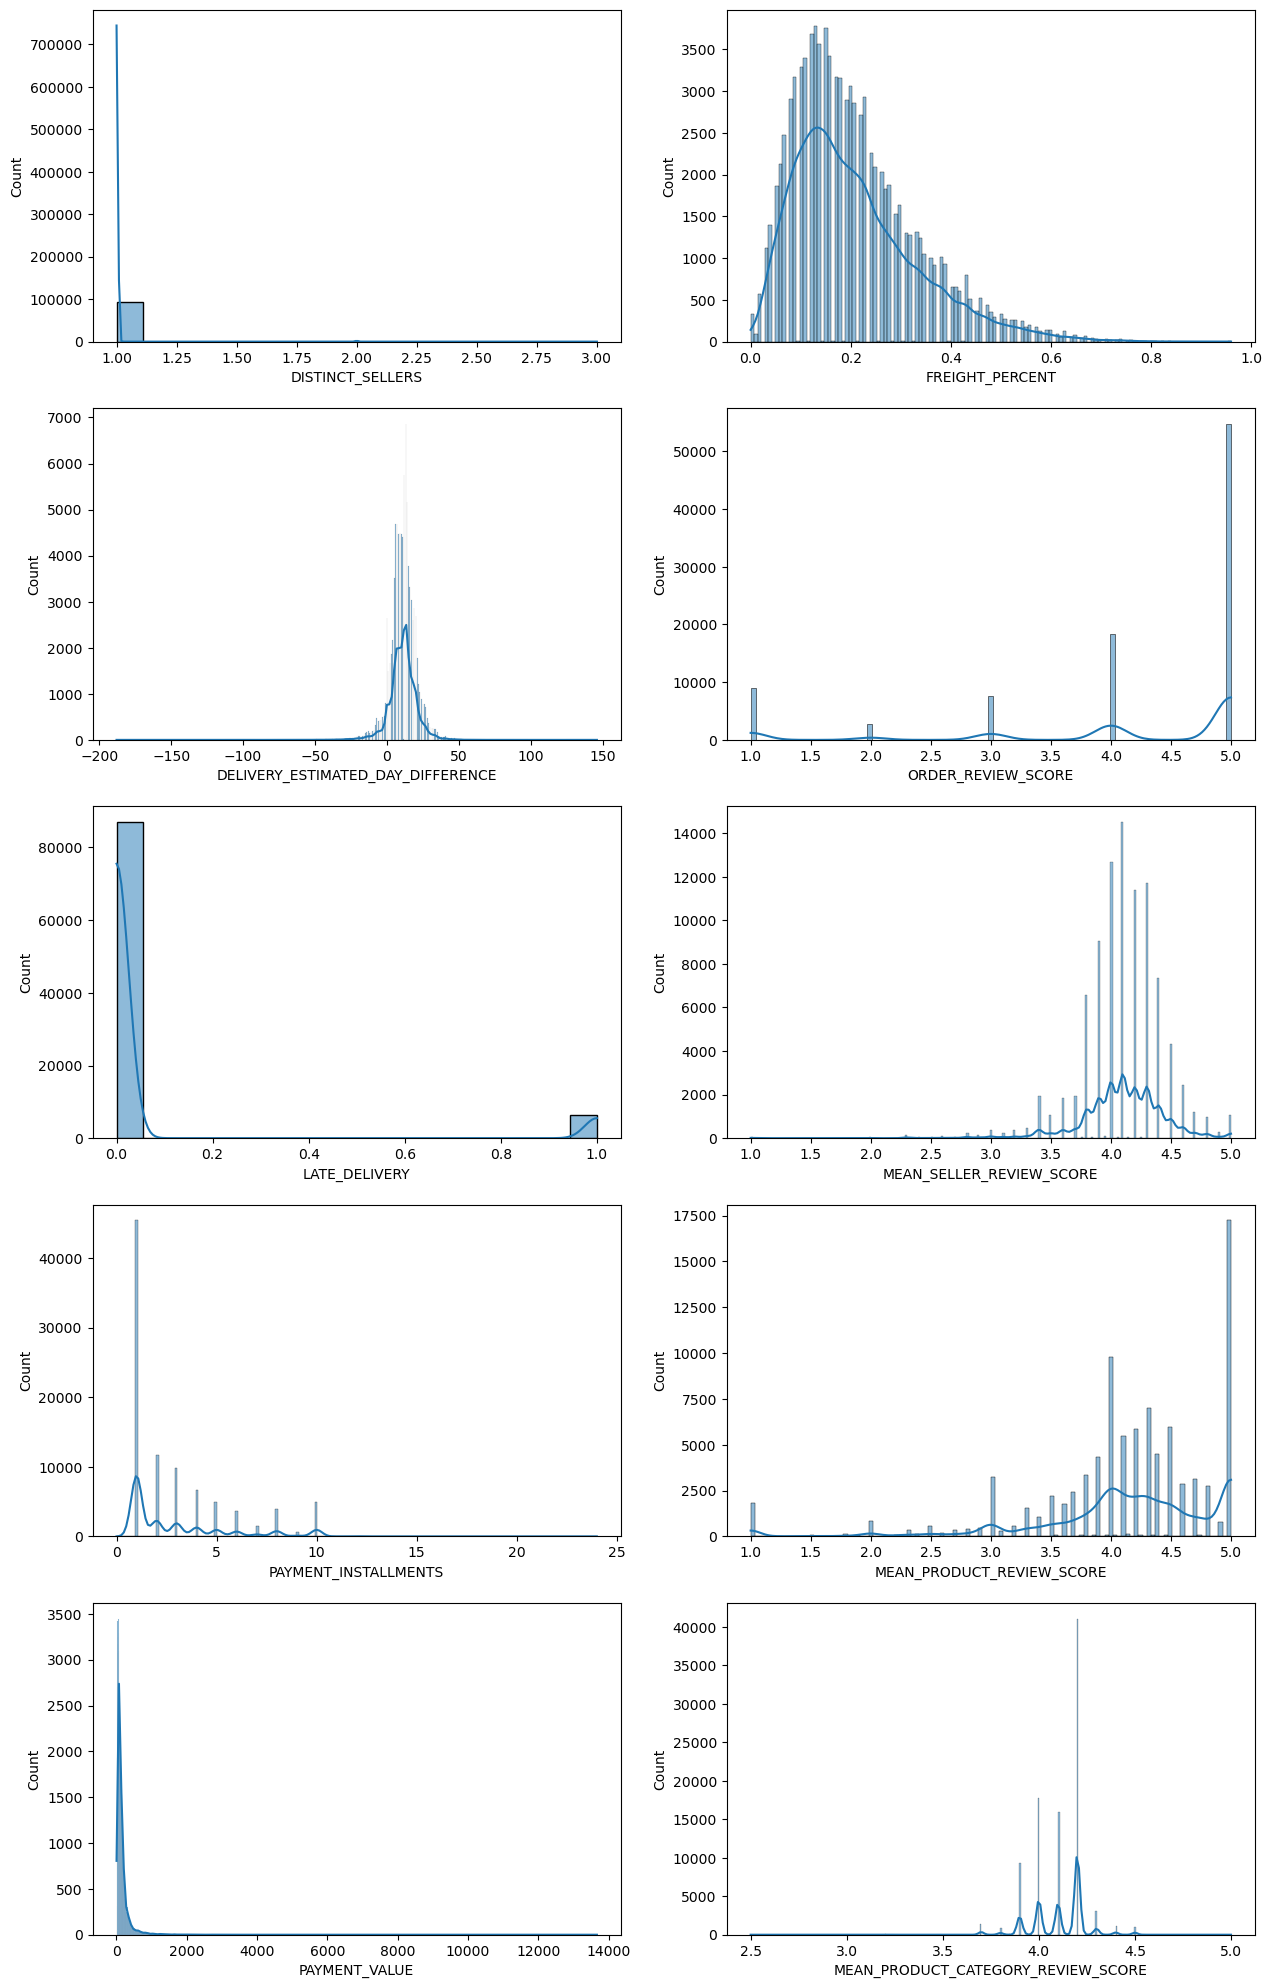

In [35]:
# Data distribution

f, axes = plt.subplots(5, 2, figsize=(15, 25))

ln, col = 0, 0
for i in range(10):
    sns.histplot(df[feat_num[i]], kde=True, ax=axes[ln][col]);
    if (ln+1)%5 == 0:
        col += 1
        ln   = 0
    else:
        ln += 1

## Tabulação cruzada e Agrupamentos

In [36]:
df.groupby(by = 'SECOND_ORDER_WITHIN_30_DAYS').mean().round(2)

,DISTINCT_SELLERS,DELIVERY_ESTIMATED_DAY_DIFFERENCE,LATE_DELIVERY,PAYMENT_INSTALLMENTS,PAYMENT_VALUE,FREIGHT_PERCENT,ORDER_REVIEW_SCORE,MEAN_SELLER_REVIEW_SCORE,MEAN_PRODUCT_REVIEW_SCORE,MEAN_PRODUCT_CATEGORY_REVIEW_SCORE
SECOND_ORDER_WITHIN_30_DAYS,,,,,,,,,,
0,1.00,10.92,0.07,2.91,160.34,0.21,4.15,4.09,4.12,4.11
1,1.01,11.61,0.07,3.40,157.93,0.22,4.06,4.06,4.06,4.09


In [37]:
pd.set_option('display.max_columns',  None)
pd.crosstab(df['SECOND_ORDER_WITHIN_30_DAYS'], [df['CUSTOMER_STATE']])

CUSTOMER_STATE,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
SECOND_ORDER_WITHIN_30_DAYS,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,75,380,139,65,3118,1246,1985,1897,1874,691,10851,668,841,909,495,1534,460,4696,11724,458,225,40,5094,3402,322,38600,264
1,1,7,1,1,40,11,33,30,20,7,147,13,14,13,9,14,4,72,189,6,5,0,73,42,5,545,3


## Contagem das classes
<p style="color: red;"><strong>MUITO DESBALANCEADA</strong></p>

In [38]:
np.unique(df['SECOND_ORDER_WITHIN_30_DAYS'], return_counts = True)

(array([0, 1]), array([92053,  1305]))

# Modelagem
****
## Métrica utilizada
Dado que queremos identificar os clientes com maiores probabilidades de fidelização, a métrica utilizada será o **RECALL**. Se o modelo tiver alto recall, significa que ele consegue identificar a maioria dos clientes com altas chances de fidelização, mesmo que isso signifique errar e classificar alguns clientes com baixa probabilidade.  
<p style="color: red"><b>explique o modelo que você escolheu e por que o escolheu. Explique também os hiperparâmetros que você usou.</b></p>

In [39]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

## Separando treino e teste

In [40]:
X, y = df.drop('SECOND_ORDER_WITHIN_30_DAYS', axis = 1), df['SECOND_ORDER_WITHIN_30_DAYS']

In [41]:
seed = 14
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = seed)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((65350, 11), (65350,), (28008, 11), (28008,))

In [42]:
np.unique(y_train, return_counts = True), np.unique(y_test, return_counts = True)

((array([0, 1]), array([64415,   935])),
 (array([0, 1]), array([27638,   370])))

## Tratando variáveis categóricas e valores nulos

In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [44]:
pipe_encoder = Pipeline(steps = [('cat_encoder', CatBoostEncoder())])

## Tratando variáveis numéricas
Essa técnica é usada para transformar as características do conjunto de dados em uma escala específica, normalmente entre 0 e 1.

In [45]:
pipe_scaler = Pipeline(steps = [('minmax_scaler', MinMaxScaler())])

## Tratando nulos
Valores nulos serão substituidos pela média

In [46]:
null_count = df.isnull().sum()
has_null_values = null_count.loc[null_count > 0].keys()
has_null_values

Index(['DELIVERY_ESTIMATED_DAY_DIFFERENCE', 'PAYMENT_INSTALLMENTS',
       'PAYMENT_VALUE', 'FREIGHT_PERCENT', 'ORDER_REVIEW_SCORE',
       'MEAN_SELLER_REVIEW_SCORE', 'MEAN_PRODUCT_REVIEW_SCORE',
       'MEAN_PRODUCT_CATEGORY_REVIEW_SCORE'],
      dtype='object')

In [47]:
pipe_imputer =  Pipeline(steps = [('simple_imp', SimpleImputer(missing_values=np.nan, strategy='mean'))])

## Ajuste de hiperparâmetros
Dado que o dataset é de caracterítstica desbalanceada, serão utilizados somente algoritmos que possuem o parâmetro **class_weight**

In [48]:
from sklearn.model_selection import RandomizedSearchCV

In [49]:
transformer_without_scaler = ColumnTransformer(transformers = [
      ('encoder', pipe_encoder, feat_cat)
], verbose = False, remainder = 'passthrough')

transformer_with_scaler = ColumnTransformer(transformers = [
      ('encoder', pipe_encoder, feat_cat)
    , ('scaler', pipe_scaler, feat_num)
], verbose = False)


imputer = ColumnTransformer(transformers = [
    ('imputer', pipe_imputer, list(range(len(feat_cat)+len(feat_num))) )
], verbose = False, remainder = 'passthrough')

In [50]:
transformer_without_scaler = Pipeline(
    steps = [('transformer', transformer_without_scaler), ('imputer', imputer)]
)

transformer_with_scaler = Pipeline(
    steps = [('transformer', transformer_with_scaler), ('imputer', imputer)]
)

In [51]:
cv = StratifiedKFold(random_state = 14, n_splits = 5, shuffle=True)

In [52]:
def use_random_search(pipeline, params, n_iter = 60):    
    rs = RandomizedSearchCV(
                            estimator           = pipeline,
                            param_distributions = params,
                            n_iter              = n_iter, 
                            scoring             = "recall",
                            n_jobs              = -1,
                            cv                  = cv,
                            random_state        = 14,
                            verbose             = True,
    )
    rs.fit(X_train, y_train)
    
    results = rs.cv_results_
    results = pd.DataFrame(data = results, columns = results.keys())
    results.sort_values(by = ['rank_test_score'] , inplace = True, ignore_index = True)
    
    best_model_params = results['params'][0]
    
    best_model_params_without_prefix = dict()
    for k, v in best_model_params.items():
        best_model_params_without_prefix[k.replace('model__', '')] = v
    best_model_params_without_prefix
    
    return {'results': results,
            'best_model_params': best_model_params,
            'best_model_params_without_prefix': best_model_params_without_prefix
           }

### Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
pipeline_rf = Pipeline(
    steps = [('transformer', transformer_without_scaler), ('model', RandomForestClassifier())]
)

In [55]:
params_rf = {
    'model__n_estimators': np.arange(50, 200, 50),
    'model__max_depth': [2, 3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2'],
    'model__bootstrap': [True, False],
    'model__class_weight': ['balanced', 'balanced_subsample'],
}

candidates = 1
for val in params_rf.values():
    candidates *= len(val)
candidates

864

In [56]:
%%time
response_rf = use_random_search(pipeline_rf, params_rf);

Fitting 5 folds for each of 60 candidates, totalling 300 fits
CPU times: user 15.7 s, sys: 326 ms, total: 16.1 s
Wall time: 7min 43s


In [57]:
response_rf['results'].head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__min_samples_split,param_model__min_samples_leaf,param_model__max_features,param_model__max_depth,param_model__class_weight,param_model__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.035637,0.183064,0.150330,0.006613,150,10,2,log2,2,balanced,False,"{'model__n_estimators': 150, 'model__min_sampl...",0.481283,0.508021,0.502674,0.502674,0.481283,0.495187,0.011519,1
1,1.778729,0.059878,0.072407,0.009411,50,10,1,sqrt,2,balanced_subsample,False,"{'model__n_estimators': 50, 'model__min_sample...",0.502674,0.486631,0.497326,0.475936,0.502674,0.493048,0.010369,2
2,3.490630,0.056443,0.109632,0.005918,100,2,2,sqrt,2,balanced,False,"{'model__n_estimators': 100, 'model__min_sampl...",0.497326,0.481283,0.529412,0.443850,0.475936,0.485561,0.027972,3
3,5.974059,0.160144,0.150310,0.007485,150,2,4,log2,2,balanced_subsample,True,"{'model__n_estimators': 150, 'model__min_sampl...",0.475936,0.502674,0.502674,0.454545,0.475936,0.482353,0.018338,4
4,3.398951,0.081729,0.108116,0.003134,100,2,4,log2,2,balanced,False,"{'model__n_estimators': 100, 'model__min_sampl...",0.475936,0.465241,0.524064,0.465241,0.475936,0.481283,0.021919,5


In [58]:
response_rf['best_model_params']

{'model__n_estimators': 150,
 'model__min_samples_split': 10,
 'model__min_samples_leaf': 2,
 'model__max_features': 'log2',
 'model__max_depth': 2,
 'model__class_weight': 'balanced',
 'model__bootstrap': False}

In [59]:
response_rf['best_model_params_without_prefix']

{'n_estimators': 150,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 2,
 'class_weight': 'balanced',
 'bootstrap': False}

### LogisticRegression

In [60]:
from sklearn.linear_model import LogisticRegression

In [61]:
pipeline_lr = Pipeline(
    steps = [('transformer', transformer_with_scaler), ('model', LogisticRegression(class_weight = 'balanced'))]
)

In [92]:
params_lr = {
      'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
      'model__C': [0.1, 0.3, 0.5, 0.7, 1.0],
      'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
      'model__max_iter': [100, 500, 1000],
}

candidates = 1
for val in params_lr.values():
    candidates *= len(val)
candidates

300

In [ ]:
%%time
response_lr = use_random_search(pipeline_lr, params_lr);

In [101]:
response_lr['results'].query('std_test_score <= 0.20').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__solver,param_model__penalty,param_model__max_iter,param_model__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,11.656389,0.093697,0.054622,0.003039,saga,l1,500,1.0,"{'model__solver': 'saga', 'model__penalty': 'l...",0.657754,0.524064,0.679144,0.358289,0.433155,0.530481,0.124469,4
5,0.669752,0.077283,0.098157,0.004980,newton-cg,none,500,0.7,"{'model__solver': 'newton-cg', 'model__penalty...",0.508021,0.524064,0.513369,0.497326,0.550802,0.518717,0.018213,6
6,1.258763,0.358313,0.096275,0.015002,lbfgs,none,1000,0.3,"{'model__solver': 'lbfgs', 'model__penalty': '...",0.508021,0.524064,0.513369,0.497326,0.550802,0.518717,0.018213,6
7,0.681020,0.056745,0.094825,0.013469,newton-cg,none,100,0.7,"{'model__solver': 'newton-cg', 'model__penalty...",0.508021,0.524064,0.513369,0.497326,0.550802,0.518717,0.018213,6
8,0.607904,0.039283,0.087531,0.006827,newton-cg,none,1000,0.7,"{'model__solver': 'newton-cg', 'model__penalty...",0.508021,0.524064,0.513369,0.497326,0.550802,0.518717,0.018213,6


In [98]:
# O melhor parâmetro apresenta Desvio Padrão muito alto
response_lr['best_model_params']

{'model__solver': 'saga',
 'model__penalty': 'l2',
 'model__max_iter': 100,
 'model__C': 0.3}

In [99]:
response_lr['best_model_params_without_prefix']

{'solver': 'saga', 'penalty': 'l2', 'max_iter': 100, 'C': 0.3}

In [107]:
response_lr['best_model_params'] = response_lr['results'].iloc[3]['params']
response_lr['best_model_params']

{'model__solver': 'saga',
 'model__penalty': 'l1',
 'model__max_iter': 500,
 'model__C': 1.0}

In [109]:
response_lr['best_model_params_without_prefix'] = dict()
for k, v in response_lr['best_model_params'].items():
    response_lr['best_model_params_without_prefix'][k.replace('model__', '')] = v
response_lr['best_model_params_without_prefix']

{'solver': 'saga', 'penalty': 'l1', 'max_iter': 500, 'C': 1.0}

### LGBMclassifier

In [67]:
%%capture
!pip install lightgbm

In [68]:
from lightgbm import LGBMClassifier

In [69]:
pipeline_lgb = Pipeline(
    steps = [('transformer', transformer_without_scaler), ('model', LGBMClassifier(class_weight = 'balanced'))]
)

In [70]:
params_lgb = {'model__learning_rate': [0.01, 0.05, 0.1, 0.5],
              'model__n_estimators': [50, 100, 500, 1000],
              'model__max_depth': [3, 5, 7, 9],
              'model__num_leaves': [31, 63, 127, 255],
              'model__min_child_samples': [10, 20, 30],
              'model__subsample': [0.6, 0.8, 1.0],
              'model__colsample_bytree': [0.6, 0.8, 1.0],
              'model__reg_alpha': [0, 0.1, 0.5, 1.0],
              'model__reg_lambda': [0, 0.1, 0.5, 1.0],
             }

candidates = 1
for val in params_lgb.values():
    candidates *= len(val)
candidates

110592

In [71]:
%%time
response_lgb = use_random_search(pipeline_lgb, params_lgb);

Fitting 5 folds for each of 60 candidates, totalling 300 fits
CPU times: user 10.5 s, sys: 417 ms, total: 10.9 s
Wall time: 16min 6s


In [72]:
response_lgb['results'].head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__reg_lambda,param_model__reg_alpha,param_model__num_leaves,param_model__n_estimators,param_model__min_child_samples,param_model__max_depth,param_model__learning_rate,param_model__colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.692626,0.261267,0.228159,0.007913,0.6,0,0.5,255,100,20,3,0.05,0.8,"{'model__subsample': 0.6, 'model__reg_lambda':...",0.422460,0.433155,0.417112,0.449198,0.470588,0.438503,0.019429,1
1,11.566883,0.695561,1.109721,0.020009,0.6,0.5,0.1,127,500,30,3,0.01,1.0,"{'model__subsample': 0.6, 'model__reg_lambda':...",0.390374,0.401070,0.433155,0.486631,0.449198,0.432086,0.034557,2
2,2.267034,0.049044,0.216896,0.004689,0.8,0.1,0.5,63,100,10,3,0.05,0.6,"{'model__subsample': 0.8, 'model__reg_lambda':...",0.406417,0.417112,0.443850,0.427807,0.459893,0.431016,0.019012,3
3,2.448336,0.182095,0.212553,0.010091,0.6,0.5,0.5,31,50,30,7,0.01,0.8,"{'model__subsample': 0.6, 'model__reg_lambda':...",0.390374,0.411765,0.443850,0.422460,0.395722,0.412834,0.019251,4
4,4.423557,0.109537,0.307154,0.018656,0.6,0.5,1.0,31,100,10,7,0.01,1.0,"{'model__subsample': 0.6, 'model__reg_lambda':...",0.374332,0.390374,0.401070,0.443850,0.406417,0.403209,0.023088,5


In [73]:
response_lgb['best_model_params']

{'model__subsample': 0.6,
 'model__reg_lambda': 0,
 'model__reg_alpha': 0.5,
 'model__num_leaves': 255,
 'model__n_estimators': 100,
 'model__min_child_samples': 20,
 'model__max_depth': 3,
 'model__learning_rate': 0.05,
 'model__colsample_bytree': 0.8}

In [74]:
response_lgb['best_model_params_without_prefix']

{'subsample': 0.6,
 'reg_lambda': 0,
 'reg_alpha': 0.5,
 'num_leaves': 255,
 'n_estimators': 100,
 'min_child_samples': 20,
 'max_depth': 3,
 'learning_rate': 0.05,
 'colsample_bytree': 0.8}

### SVC

In [75]:
from sklearn.svm import SVC

In [86]:
pipeline_svc = Pipeline(
    steps = [('transformer', transformer_with_scaler), ('model', SVC(class_weight = 'balanced', cache_size = 900))]
)

In [87]:
params_svc = {'model__C': [0.1, 1, 10],
              'model__kernel': ['rbf', 'sigmoid'],
              'model__gamma': ['scale', 'auto'] + list(np.logspace(-2, 2, 5)),
              'model__coef0': [0, 1, 2],
              'model__shrinking': [True],
             }

candidates = 1
for val in params_svc.values():
    candidates *= len(val)
candidates

126

In [88]:
%%time
response_svc = use_random_search(pipeline_svc, params_svc, n_iter = 3);

Fitting 5 folds for each of 3 candidates, totalling 15 fits
CPU times: user 40min 44s, sys: 1.4 s, total: 40min 46s
Wall time: 40min 48s


In [89]:
response_svc['results'].head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__shrinking,param_model__kernel,param_model__gamma,param_model__coef0,param_model__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,123.688137,2.578582,28.680653,0.224511,True,rbf,1.0,2,10,"{'model__shrinking': True, 'model__kernel': 'r...",0.427807,0.390374,0.390374,0.422460,0.42246,0.410695,0.016706,1
1,167.114936,10.673961,32.118336,0.172646,True,rbf,0.1,1,0.1,"{'model__shrinking': True, 'model__kernel': 'r...",0.395722,0.401070,0.352941,0.433155,0.42246,0.401070,0.027684,2
2,75.386262,0.352978,20.504480,0.105108,True,sigmoid,100.0,1,10,"{'model__shrinking': True, 'model__kernel': 's...",0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,3


In [90]:
response_svc['best_model_params']

{'model__shrinking': True,
 'model__kernel': 'rbf',
 'model__gamma': 1.0,
 'model__coef0': 2,
 'model__C': 10}

In [91]:
response_svc['best_model_params_without_prefix']

{'shrinking': True, 'kernel': 'rbf', 'gamma': 1.0, 'coef0': 2, 'C': 10}

## Validando com os hiperparâmetros
- Será avaliado o recall de ambas as classes para não piorar o desempenho na classe majoritária
- Nesta etapa, será utilizado o modelo RandomForest dado que obteve o melhor recall e menor desvio padrão das amostras no ajuste de hiperparâmetros

In [110]:
from sklearn.metrics import make_scorer, recall_score

def class_0_recall(y_true, y_pred):
    recall_class = recall_score(y_true, y_pred, pos_label=0)
    return recall_class

def class_1_recall(y_true, y_pred):
    recall_class = recall_score(y_true, y_pred, pos_label=1)
    return recall_class

scorer_0 = make_scorer(class_0_recall, greater_is_better=True)
scorer_1 = make_scorer(class_1_recall, greater_is_better=True)

In [115]:
pipeline_rf = Pipeline(
    steps = [('transformer', transformer_without_scaler), ('model', RandomForestClassifier(**response_rf['best_model_params_without_prefix']))]
)

CPU times: user 301 µs, sys: 0 ns, total: 301 µs
Wall time: 313 µs


In [117]:
%%time
scores_class_0 = cross_val_score(pipeline_rf,
                 X_train, y_train, cv = cv,
                 scoring = scorer_0, 
                 n_jobs = -1)

scores_class_1 = cross_val_score(pipeline_rf,
                 X_train, y_train, cv = cv,
                 scoring = scorer_1, 
                 n_jobs = -1)

CPU times: user 39.4 s, sys: 34 ms, total: 39.5 s
Wall time: 39.5 s


In [118]:
print('='*60)
print(f'\nrecall score (class 0): {round(scores_class_0.mean(), 2)} ({round(scores_class_0.std(), 2)} desvio padrão)')
print(f'\nrecall score (class 1): {round(scores_class_1.mean(), 2)} ({round(scores_class_1.std(), 2)} desvio padrão)')


recall score (class 0): 0.62 (0.04 desvio padrão)

recall score (class 1): 0.49 (0.02 desvio padrão)


## Ajuste dos pesos

In [133]:
from sklearn.utils.class_weight import compute_class_weight

In [138]:
# Estimando os pesos de amostra por classe para conjuntos de dados não balanceados.
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}
class_weights

{0: 0.5072576263292712, 1: 34.94652406417112}

In [170]:
# Os pesos foram escolhidos após dezenas de rodadas de teste. O output abaixo representa a última rodada de teste
qtd_amostras = 10

class_weights_list = list()
class_weight_0 = np.linspace(class_weights[0], class_weights[0]*0.99, qtd_amostras)
class_weight_1 = np.linspace(37.27629233511587, 38.052881758764116, qtd_amostras)

for w_0, w_1 in zip(class_weight_0, class_weight_1):
    class_weights_list.append( {0: w_0,1: w_1} )
class_weights_list

[{0: 0.5072576263292712, 1: 37.27629233511587},
 {0: 0.5066940067444609, 1: 37.36258004885456},
 {0: 0.5061303871596505, 1: 37.44886776259326},
 {0: 0.5055667675748403, 1: 37.53515547633195},
 {0: 0.50500314799003, 1: 37.62144319007064},
 {0: 0.5044395284052197, 1: 37.70773090380934},
 {0: 0.5038759088204093, 1: 37.79401861754803},
 {0: 0.5033122892355991, 1: 37.880306331286725},
 {0: 0.5027486696507888, 1: 37.966594045025424},
 {0: 0.5021850500659785, 1: 38.052881758764116}]

In [171]:
for class_weight in class_weights_list:
    response_rf['best_model_params_without_prefix']['class_weight'] = class_weight
    pipeline_rf = Pipeline(
                    steps = [('transformer', transformer_without_scaler), ('model', RandomForestClassifier(**response_rf['best_model_params_without_prefix']))]
                    )
    scores_class_0 = cross_val_score(pipeline_rf,
                     X_train, y_train, cv = cv,
                     scoring = scorer_0, 
                     n_jobs = -1)

    scores_class_1 = cross_val_score(pipeline_rf,
                     X_train, y_train, cv = cv,
                     scoring = scorer_1, 
                     n_jobs = -1)
    
    print('='*60)
    print(f'weights: {class_weight}')
    print(f'\nrecall score (class 0): {round(scores_class_0.mean(), 2)} ({round(scores_class_0.std(), 2)} DP)')
    print(f'\nrecall score (class 1): {round(scores_class_1.mean(), 2)} ({round(scores_class_1.std(), 2)} DP)')

weights: {0: 0.5072576263292712, 1: 37.27629233511587}

recall score (class 0): 0.49 (0.04 DP)

recall score (class 1): 0.64 (0.06 DP)
weights: {0: 0.5066940067444609, 1: 37.36258004885456}

recall score (class 0): 0.45 (0.06 DP)

recall score (class 1): 0.62 (0.04 DP)
weights: {0: 0.5061303871596505, 1: 37.44886776259326}

recall score (class 0): 0.45 (0.06 DP)

recall score (class 1): 0.64 (0.05 DP)
weights: {0: 0.5055667675748403, 1: 37.53515547633195}

recall score (class 0): 0.46 (0.06 DP)

recall score (class 1): 0.64 (0.04 DP)
weights: {0: 0.50500314799003, 1: 37.62144319007064}

recall score (class 0): 0.43 (0.05 DP)

recall score (class 1): 0.65 (0.04 DP)
weights: {0: 0.5044395284052197, 1: 37.70773090380934}

recall score (class 0): 0.42 (0.06 DP)

recall score (class 1): 0.68 (0.05 DP)
weights: {0: 0.5038759088204093, 1: 37.79401861754803}

recall score (class 0): 0.39 (0.03 DP)

recall score (class 1): 0.66 (0.06 DP)
weights: {0: 0.5033122892355991, 1: 37.880306331286725}



# Resultados
****

In [179]:
response_rf['best_model_params_without_prefix']['class_weight'] = {0: 0.49640794932167287, 1: 37.66458704693999}
params = response_rf['best_model_params_without_prefix']

pipeline_model = Pipeline(
                    steps = [('transformer', transformer_without_scaler), ('model', RandomForestClassifier(**params))]
                    )

In [180]:
model = pipeline_model.fit(X_train, y_train)

In [181]:
y_pred = model.predict(X_test)

In [182]:
recall_class_1 = recall_score(y_test, y_pred, pos_label=1)

In [187]:
print(f'Quando o cliente fez uma segunda compra em até 30 dias, o modelo previu corretamente {round(recall_class_1*100, 1)}% dos casos.')

Quando o cliente fez uma segunda compra em até 30 dias, o modelo previu corretamente 71.1% dos casos.


# Conclusão
****
*faça uma conclusão sobre o seu projeto, destacando seus resultados e eventuais limitações ou desafios que você enfrentou durante o processo.*  
Neste projeto tive a limitação de não trabalhar com o PL/SQL. O que dificultou no desenvolvimento das métricas na etapa de pré-processamento dos dados. No uso desse modelo na vida real, a escrita de código procedural no banco de dados com o PL/SQL seria essencial para executar tarefas mais complexas, como processamento de dados, lógica de negócios, manipulação de exceções, entre outras coisas.